## Observations and Insights 

In [ ]:
#You must use proper labeling of your plots, to include properties such as: plot titles, axis labels, legend labels, 
#_x_-axis and _y_-axis limits, etc.

#See the [starter workbook](Pymaceuticals/pymaceuticals_starter.ipynb) for help on what modules to import and 
#expected format of the notebook.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from itertools import cycle, islice
#import seaborn as sns

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)
study_results = study_results.rename(columns={"Drug Regimen":"Drug_Regimen"})
mouse_metadata = mouse_metadata.rename(columns={"Drug Regimen":"Drug_Regimen"})

mouse_study_df = pd.merge(mouse_metadata, study_results)

mouse_study_df

,Mouse ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [2]:
# Checking the number of mice.
a = mouse_metadata["Mouse ID"].nunique()
b = study_results["Mouse ID"].nunique()
c = mouse_study_df["Mouse ID"].nunique()
a, b, c

(249, 249, 249)

In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
#https://stackoverflow.com/questions/29276958/identifying-duplicate-pairs-in-python-pandas
find_dup = mouse_study_df.groupby(['Mouse ID', 'Timepoint']).size()                                 
find_dup = find_dup[find_dup > 1]
find_dup

Mouse ID  Timepoint
g989      0            2
          5            2
          10           2
          15           2
          20           2
dtype: int64

In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
# One copy of g989 seems to have died...
dup = mouse_study_df.loc[mouse_study_df['Mouse ID'] == "g989"]
dup

,Mouse ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mouse_study_clean_df = mouse_study_df[mouse_study_df["Mouse ID"] != "g989"]
mouse_study_clean_df.rename(columns={"Drug Regimen":"Drug_Regimen"})
mouse_study_clean_df

,Mouse ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [6]:
# Checking the number of mice in the clean DataFrame.
mouse_study_clean_df["Mouse ID"].nunique()

248

## Summary Statistics

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method is the most straighforward, creating multiple series and putting them all together at the end.
mice_by_drugs = mouse_study_clean_df.groupby("Drug_Regimen")
#mice_by_drugs
mean = mice_by_drugs["Tumor Volume (mm3)"].mean()
median = mice_by_drugs["Tumor Volume (mm3)"].median()
variance = mice_by_drugs["Tumor Volume (mm3)"].var()
std = mice_by_drugs["Tumor Volume (mm3)"].std()
sem = mice_by_drugs["Tumor Volume (mm3)"].sem()

mouse_study_stats_df = pd.merge(mean, median, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor Volume (mm3)_x":"mean", "Tumor Volume (mm3)_y":"median"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, variance, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor Volume (mm3)":"variance"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, std, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor Volume (mm3)":"std"})
mouse_study_stats_df = pd.merge(mouse_study_stats_df, sem, on=["Drug_Regimen"])
mouse_study_stats_df = mouse_study_stats_df.rename(columns = {"Tumor Volume (mm3)":"sem"})

mouse_study_stats_df

#astype (int)

,mean,median,variance,std,sem
Drug_Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [ ]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function
#https://stackoverflow.com/questions/55388610/how-to-calculate-aggregated-summary-statistics-in-pandas-dataframe

mouse_study_clean_df.groupby(["Drug Regimen"]).agg({"Tumor Volume (mm3)":['mean', 'median', 'var', 'std', 'sem']})


## Bar and Pie Charts

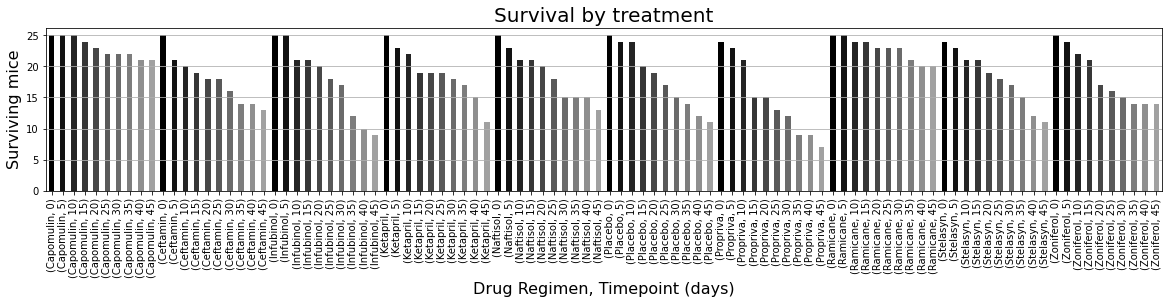

In [9]:
#Generate a bar plot using `DataFrame.plot()` that shows  the number of 
#total mice for each treatment regimen throughout the course of the study.

#In real life I would probably go to Illustrator to make a more user-friendly x-axis.
#Would be nice to somehow separate placebo.

drug_group = mouse_study_clean_df.groupby(['Drug_Regimen', 'Timepoint'])
count_mice = drug_group['Mouse ID'].count()
#count_mice_df = count_mice.to_frame()
my_colors = list(islice(cycle(['0', '.07', '0.14', '0.21', '0.28', '0.35', '0.42', '0.49', '0.56', '0.63']), None, len(drug_group)))

ax=count_mice.plot(kind="bar", figsize=(20,3), legend=False, title="Survival by treatment", color=my_colors)

ax.set_ylabel("Surviving mice", size=16)
ax.set_xlabel("Drug Regimen, Timepoint (days)", size=16)
ax.set_title("Survival by treatment", size=20)
ax.grid(axis='y')

#https://stackoverflow.com/questions/43545879/bar-chart-with-multiple-labels
#ax = plt.gca()
#pos = []
#for bar in ax.patches:
#    pos.append(bar.get_x()+bar.get_width()/2.)
#ax.set_xticks(pos,minor=True)
#lab = []
#for i in range(len(pos)):
#    l = count_mice_df.columns.values[i//len(count_mice_df.index.values)]
#    lab.append(l)

#ax.set_xticklabels(lab,minor=True)
#ax.tick_params(axis='x', which='major')
#plt.setp(ax.get_xticklabels(), rotation=90)

    
#drug_group['idx'] = drug_group.groupby("Drug Regimen").cumcount()
#drug_group.set_index(["Drug Regimen", 'idx'], inplace=True)
#drug_group.unstack().plot.bar(legend=False, color='xkcd:grassy green', title='TITLE')


#https://stackoverflow.com/questions/53734646/group-dataframe-column-graph-based-on-common-x-axis-values
#df['idx'] = df.groupby('year').cumcount()
#df.set_index(['year', 'idx'], inplace=True)
#df.unstack().plot.bar(legend=False, color='xkcd:grassy green', title='TITLE')

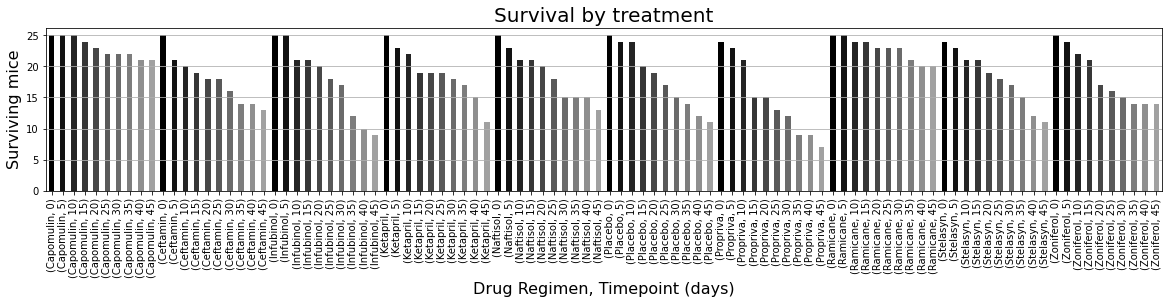

In [10]:
#Generate a bar plot using Matplotlib's `pyplot`.

#In real life I would probably go to Illustrator to make a more user-friendly x-axis.
#Would be nice to somehow separate placebo.

drug_group = mouse_study_clean_df.groupby(['Drug_Regimen', 'Timepoint'])
count_mice = drug_group['Mouse ID'].count()

colors = '0', '.07', '0.14', '0.21', '0.28', '0.35', '0.42', '0.49', '0.56', '0.63'

count_chart = count_mice.plot(kind='bar', color=colors, figsize=(20,3))
plt.title("Survival by treatment", size=20)
plt.ylabel("Surviving mice", size=16)
plt.xlabel("Drug Regimen, Timepoint (days)", size=16)
plt.grid(axis='y')
plt.show()

Text(0.5, 1.0, 'Mice by sex')

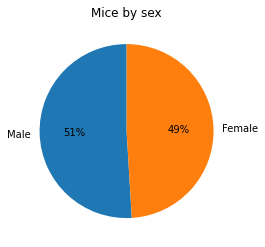

In [11]:
#Generate a pie plot using Pandas's `DataFrame.plot()` that shows the distribution of female or male mice in the study.

ax=mouse_study_clean_df['Sex'].value_counts().plot.pie(startangle=90, autopct='%1.0f%%', label='')
ax.set_title("Mice by sex")



<function matplotlib.pyplot.show(*args, **kw)>

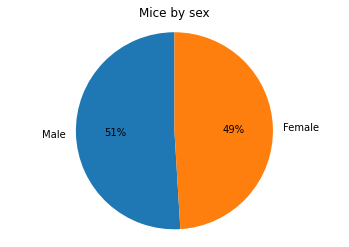

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot


#Generate a pie plot using both Pandas's `DataFrame.plot()` and Matplotlib's `pyplot` that shows the distribution of female or male mice in the study.
#https://datatofish.com/pie-chart-matplotlib/
#NOTE:** These plots should look identical.

#mouse_study_clean_df['Sex'].value_counts().plot.pie()

#import matplotlib.pyplot as plt
labels="Male", "Female"
plt.pie(mouse_study_clean_df['Sex'].value_counts(), labels=labels, autopct='%1.0f%%', startangle=90)
plt.title("Mice by sex")
plt.axis('equal')
plt.show


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
#sizes = [15, 30, 45, 10]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        #shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.show()

#my_data = [value1,value2,value3,...]
#my_labels = 'label1','label2','label3',...
#plt.pie(my_data,labels=my_labels,autopct='%1.1f%%')
#plt.title('My Title')
#plt.axis('equal')
#plt.show()

## Quartiles, Outliers and Boxplots

drugs = list(mouse_study_stats_df.axes[0].tolist())
time_points = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
mouse_IDs = list(mouse_study_clean_df.axes[1].tolist())
mouse_IDs = mouse_study_clean_df.('Mouse ID').unique()
mouse_IDs

In [53]:
#Calculate the final tumor volume of each mouse across four of the most promising treatment 
#regimens: Capomulin, Ramicane, Infubinol, and Ceftamin. Calculate the quartiles and IQR and 
#quantitatively determine if there are any potential outliers across all four treatment regimens.



# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse

#drugs = list(mouse_study_stats_df.axes[0].tolist()) 
#time_points = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45] 
#mouse_IDs = mouse_study_clean_df['Mouse ID'].unique()
#last_timepoint_df = mouse_study_clean_df[mouse_study_clean_df['Timepoint'] == 45]



best_drugs_list = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

best_drugs_df = mouse_study_clean_df[mouse_study_clean_df['Drug_Regimen'].isin(best_drugs_list)]
#best_drugs_df

best_drugs_by_mouse_and_drug = best_drugs_df.groupby(["Drug_Regimen", "Mouse ID"])
best_drugs_final_timepoints = best_drugs_by_mouse_and_drug["Timepoint"].max()
best_drugs_final_timepoints = best_drugs_final_timepoints.to_frame()
#best_drugs_final_timepoints

#mean = mice_by_drugs["Tumor Volume (mm3)"].mean()
#last_timepoint_best_drugs_df = last_timepoint_best_drugs_df.sort_values("Mouse ID")
#last_timepoint_best_drugs_df
#best_drugs_df["Mouse ID"].nunique()


/Users/bmacgreg/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
#Using Matplotlib, generate a box and whisker plot of the final tumor volume for all four treatment regimens 
#and highlight any potential outliers in the plot by changing their color and style.

#Hint**: All four box plots should be within the same figure. Use this [Matplotlib documentation page]
#(https://matplotlib.org/gallery/pyplots/boxplot_demo_pyplot.html#sphx-glr-gallery-pyplots-boxplot-demo-pyplot-py) 
#for help with changing the style of the outliers.








# Put treatments into a list for for loop (and later for plot labels)
drugs = list(mouse_study_stats_df.axes[0].tolist()) 
drugs
# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [ ]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [ ]:
#Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin treatment regimen.

#Select a mouse that was treated with Capomulin and generate a line plot of tumor volume vs. timepoint for that mouse.


# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin


In [ ]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen


## Correlation and Regression

In [ ]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

#Calculate the correlation coefficient and linear regression model between mouse weight and average tumor volume 
#for the Capomulin treatment. Plot the linear regression model on top of the previous scatter plot.


In [ ]:
#Look across all previously generated figures and tables and write at least three observations or inferences 
#that can be made from the data. Include these observations at the top of notebook.